<a href="https://colab.research.google.com/github/JaredStites/rock-paper-scissors/blob/main/Rock_Paper_Scissors_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import albumentations as A
import matplotlib.pyplot as plt

from functools import partial
from tensorflow.python.data import AUTOTUNE
from tensorflow.keras.layers import Rescaling

import tensorflow as tf
import tensorflow_hub as hub

import random
import os

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
cp kaggle.json ~/.kaggle/

In [ ]:
# Need to upload kaggle.json to notebook
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download glushko/rock-paper-scissors-dataset

 98% 345M/352M [00:06<00:00, 56.2MB/s]
100% 352M/352M [00:06<00:00, 59.1MB/s]


In [ ]:
!unzip /content/rock-paper-scissors-dataset.zip

In [ ]:
! kaggle datasets download sanikamal/rock-paper-scissors-dataset --force

 99% 447M/452M [00:10<00:00, 69.4MB/s]
100% 452M/452M [00:10<00:00, 45.6MB/s]


In [ ]:
!unzip /content/rock-paper-scissors-dataset.zip

In [ ]:
class_names = (
    "rock",
    "paper",
    "scissors",
)

In [ ]:
TRAIN_DIR_A = '/content/train'
TEST_DIR = '/content/test'
VAL_DIR_A = '/content/val'
TRAIN_DIR_B = '/content/Rock-Paper-Scissors/train'
VAL_DIR_B = '/content/Rock-Paper-Scissors/test'
IMAGE_SIZE = 224
BATCH_SIZE = 28

In [ ]:
def get_dataset_stats(dataset_path_a: str, dataset_path_b: str, image_pattern: str = "*.png"):
    total_samples = 0
    dataset_stats = {}

    for class_name in class_names:
        images_a = tf.io.gfile.glob(os.path.join(dataset_path_a, class_name, image_pattern))
        num_images = len(images_a)
        images_b = tf.io.gfile.glob(os.path.join(dataset_path_b, class_name, image_pattern))
        num_images += len(images_b)

        dataset_stats[class_name] = num_images
        total_samples += num_images

    dataset_stats["total"] = total_samples

    return dataset_stats


**Preprocessing images**

In [ ]:
#Augmentation pipeline using albumentations api to increase training data
transforms = A.Compose(
    [
        A.VerticalFlip(),
        A.HorizontalFlip(),
        A.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.1, brightness_by_max=False
        ),
        A.HueSaturationValue(
            p=1.0,
            hue_shift_limit=(-20, 20),
            sat_shift_limit=(-30, 30),
            val_shift_limit=(-20, 20),
        ),
        A.GaussNoise(p=1.0, var_limit=(10.0, 50.0)),
        A.MotionBlur(p=1.0, blur_limit=(3, 6)),
        A.CoarseDropout(
            p=0.8,
            max_holes=50,
            max_height=10,
            max_width=10,
            min_holes=20,
            min_height=8,
            min_width=8,
        ),
        A.ImageCompression(
            p=0.5, quality_lower=80, quality_upper=100, compression_type=0
        ),
        A.ISONoise(p=1.0, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
    ]
)

In [ ]:
#Rescales image pixels between [-1,1]
#May want to change scale to [0,1] to explore data
def rescale(
    inputs: tf.Tensor,
    labels: tf.Tensor):
  print(type(inputs))
  print(type(labels))
  return Rescaling(1.0 / 127.5, offset=-1)(inputs), labels

In [ ]:
def augment_image(
    inputs: tf.Tensor,
    labels: tf.Tensor,
    augmentation_pipeline: A.Compose,
    seed: int = 42,
):
    def apply_augmentation(images):
        random.seed(seed)
        np.random.seed(seed)

        augmented_images = []

        for img in images:
            aug_data = augmentation_pipeline(image=img.astype("uint8"))
            augmented_images.append(aug_data["image"])

        return np.stack(augmented_images)

    inputs = tf.numpy_function(func=apply_augmentation, inp=[inputs], Tout=tf.uint8)

    return inputs, labels

In [ ]:
def get_train_images(train_path, augmentation_pipeline, batch_size, image_size, seed):
 
  augment = partial(
        augment_image, augmentation_pipeline=augmentation_pipeline, seed=seed,
    )
 
  images = tf.keras.utils.image_dataset_from_directory(
      train_path, class_names=class_names, image_size=(IMAGE_SIZE,IMAGE_SIZE), seed=42
      )

  images = images.map(augment, num_parallel_calls=AUTOTUNE)

  images = images.map(rescale)

  return images.shuffle(buffer_size=512, seed=seed).prefetch(AUTOTUNE)

In [ ]:
def get_val_images(val_path, batch_size, image_size, seed):
 
  images = tf.keras.utils.image_dataset_from_directory(
      val_path, class_names=class_names, image_size=(IMAGE_SIZE,IMAGE_SIZE), seed=42
      )
  
  images = images.map(rescale)

  return images.prefetch(AUTOTUNE)

In [ ]:
train_images_A = get_train_images(TRAIN_DIR_A, transforms, BATCH_SIZE, IMAGE_SIZE, 42)
train_images_B = get_train_images(TRAIN_DIR_B, transforms, BATCH_SIZE, IMAGE_SIZE, 42)
val_images_A = get_val_images(VAL_DIR_A, BATCH_SIZE, IMAGE_SIZE, 42)
val_images_B = get_val_images(VAL_DIR_B, BATCH_SIZE, IMAGE_SIZE, 42)

train_images = train_images_A.concatenate(train_images_B)
val_images = val_images_A.concatenate(val_images_B)

Found 1020 files belonging to 3 classes.
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
Found 2520 files belonging to 3 classes.
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
Found 804 files belonging to 3 classes.
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
Found 372 files belonging to 3 classes.
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


**Explore training dataset**

In [ ]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

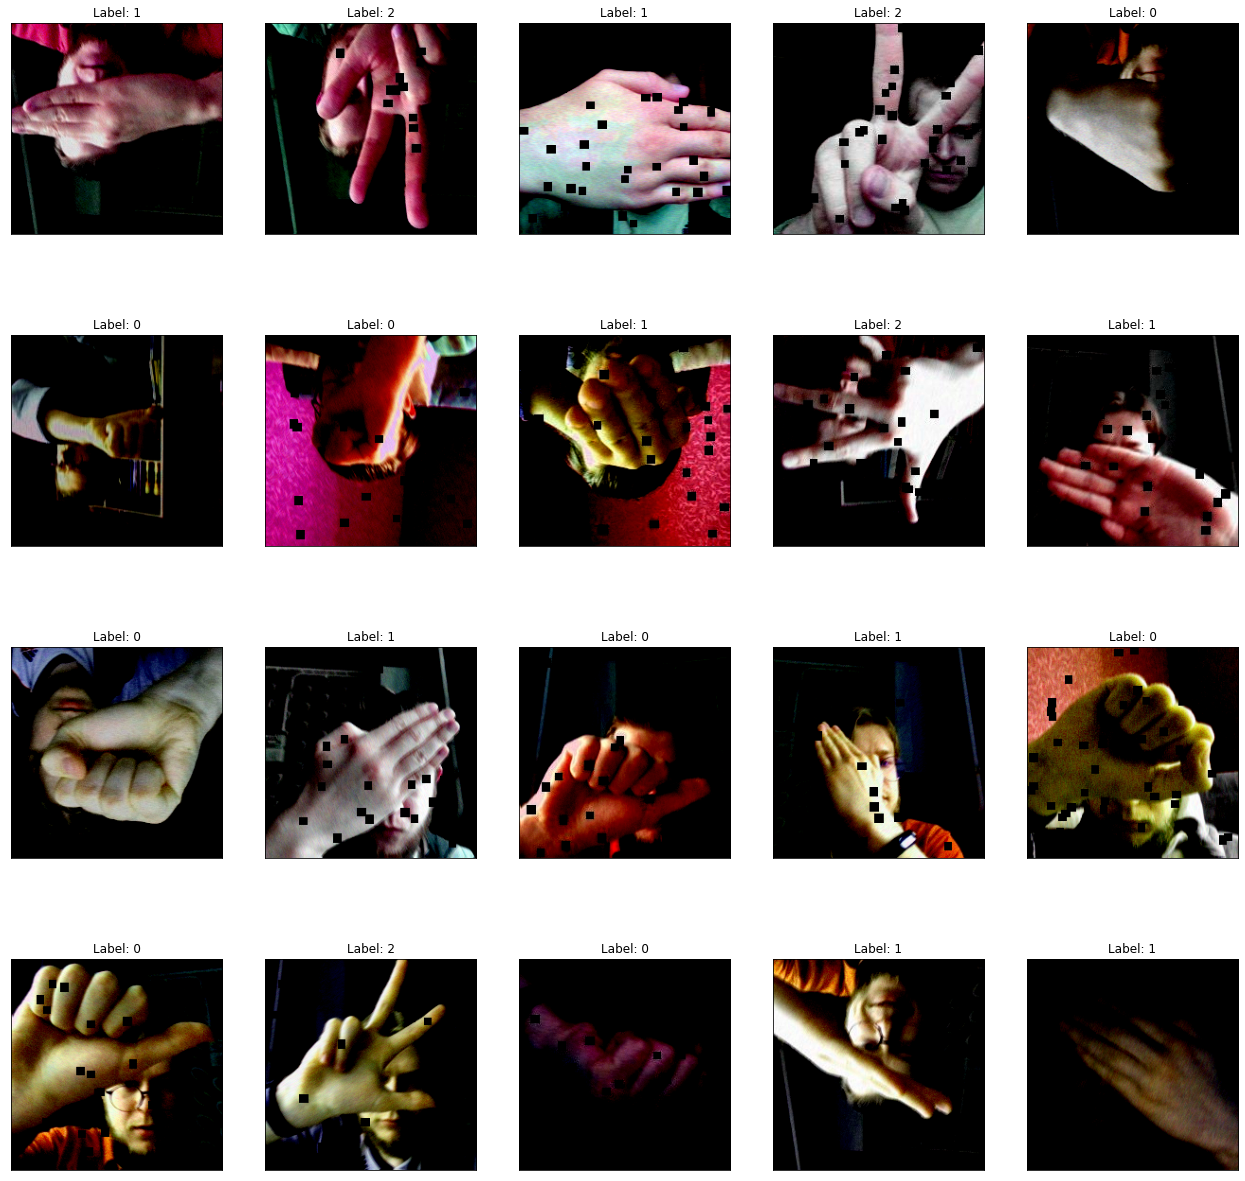

In [ ]:
view_image(train_images)

**Building Model**

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
	input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
  	include_top=False,
  	weights='imagenet',
  	pooling='avg'
)

base_model.trainable = True

for layer in base_model.layers[:100]:
            layer.trainable = False

print("Number of layers in the feature extractor: ", len(base_model.layers))

9420800/9406464 [==============================] - 0s 0us/step
Number of layers in the feature extractor:  155


In [ ]:
model = tf.keras.models.Sequential()

model.add(base_model)
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(
	units=3,
  activation='softmax',
  kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
))

In [ ]:
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(
    optimizer=rmsprop_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 1,865,283
Non-trainable params: 396,544
_________________________________________________________________


In [ ]:
train_dataset_stats = get_dataset_stats(TRAIN_DIR_A, TRAIN_DIR_B)
val_dataset_stats = get_dataset_stats(VAL_DIR_A, VAL_DIR_B)

steps_per_epoch = train_dataset_stats["total"] // BATCH_SIZE
validation_steps = val_dataset_stats["total"] // BATCH_SIZE

**Train model**

In [ ]:
EPOCHS = 50

history = model.fit(
    x=train_images.repeat(),
    validation_data=val_images.repeat(),
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            min_delta=0.001,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
126/126 [==============================] - 112s 607ms/step - loss: 0.4422 - accuracy: 0.8647 - val_loss: 18.6509 - val_accuracy: 0.3305
Epoch 2/50
126/126 [==============================] - 73s 581ms/step - loss: 0.2216 - accuracy: 0.9370 - val_loss: 8.8124 - val_accuracy: 0.5483
Epoch 3/50
126/126 [==============================] - 115s 920ms/step - loss: 0.1507 - accuracy: 0.9565 - val_loss: 13.1879 - val_accuracy: 0.4601
Epoch 4/50
126/126 [==============================] - 73s 584ms/step - loss: 0.1100 - accuracy: 0.9672 - val_loss: 5.7372 - val_accuracy: 0.4969
Epoch 5/50
126/126 [==============================] - 73s 585ms/step - loss: 0.0882 - accuracy: 0.9744 - val_loss: 11.2995 - val_accuracy: 0.4041
Epoch 6/50
126/126 [==============================] - 73s 583ms/step - loss: 0.0852 - accuracy: 0.9753 - val_loss: 7.0112 - val_accuracy: 0.4946
Epoch 7/50
126/126 [==============================] - 73s 587ms/step - loss: 0.0683 - accuracy: 0.9786 - val_loss: 7.4110 - v

**Evaluate Model**

In [ ]:
val_loss, val_accuracy = model.evaluate(val_images)

print("Val Loss: {}".format(val_loss))
print("Val Accuracy: {}".format(val_accuracy))

38/38 [==============================] - 4s 87ms/step - loss: 1.0721 - accuracy: 0.8214
Val Loss: 1.072111964225769
Val Accuracy: 0.8214285969734192


In [ ]:
def get_test_images(
    test_path: int, 
    batch_size: int, 
    seed: int):
 
  images = tf.keras.utils.image_dataset_from_directory(
      TEST_DIR, class_names=class_names, image_size=(IMAGE_SIZE,IMAGE_SIZE), seed=seed
      )
  
  images = images.map(rescale)

  return images.prefetch(AUTOTUNE)

In [ ]:
test_images = get_test_images(TEST_DIR, BATCH_SIZE, 42)

Found 540 files belonging to 3 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_images)

print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_accuracy))

17/17 [==============================] - 2s 82ms/step - loss: 1.4467 - accuracy: 0.7593
Test Loss: 1.446747899055481
Test Accuracy: 0.7592592835426331


In [ ]:
model_name = 'rock_paper_scissors_mobilenet_v2.h5'
model.save(model_name, save_format='h5')
tf.keras.models.save_model(model, './SavedModel')

In [ ]:
!zip -r model.zip {'/content/SavedModel'}

  adding: content/SavedModel/ (stored 0%)
  adding: content/SavedModel/keras_metadata.pb (deflated 96%)
  adding: content/SavedModel/assets/ (stored 0%)
  adding: content/SavedModel/saved_model.pb (deflated 91%)
  adding: content/SavedModel/variables/ (stored 0%)
  adding: content/SavedModel/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/SavedModel/variables/variables.index (deflated 77%)


In [ ]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>